# A comparison of the performance of Koopman versus the Vanilla benchmark
Tested on one month in 2017 for all zones. Trained on the 11 preceding years. Then a 52 day gap. Then tested for one month.

In [1]:
import torch
import random
import numpy as np
import pandas as pd
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats import norm, skewnorm, skew
from sklearn import linear_model

In [2]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [3]:
from koopman_probabilistic import *
from model_objs import *
import vanilla_benchmark

## Pinball Loss

In [4]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [5]:
normal_pdf = lambda mu, sigma, x: np.exp(-(x - mu)**2 / (2 * sigma**2))/(np.sqrt(2 * np.pi * sigma**2))

In [6]:
def rms(x, axis=None):
    if axis is not None:
        return np.sqrt(np.sum(x**2, axis=axis) / x.shape[axis])
    return np.sqrt(np.sum(x**2) / x.size)

# load data

In [7]:
import json

with open("GEFCom2017\\GEFCom2017-Qual\\GEFCom2017QualAll.json") as f:
    all_data = json.loads(f.read())

In [8]:
dates = np.array(list(map(pd.Timestamp, all_data["ISONE CA"]["Date"])))
zones = list(all_data.keys())
print(zones)

['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']


# SELECT A MONTH TO TEST FOR ALL ZONES

In [9]:
month_name = "May"  # <<<< CHOOSE A MONTH
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_idx = months.index(month_name)
print("Testing on month", months[month_idx])
test_start_date = pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00")
test_start = np.argwhere(dates == test_start_date)[0, 0]
test_length = 31 * 24

Testing on month May


In [10]:
delay_delta = pd.Timedelta(days=52)
delay = delay_delta.days * 24
train_end_date = test_start_date - delay_delta
train_start_date = train_end_date.replace(year=train_end_date.year - 11)
train_start = np.argwhere(dates == train_start_date)[0, 0]
train_length_delta = train_end_date - train_start_date
train_through = train_length_delta.days * 24
pre_length_delta = train_length_delta * 0.5 # the length of time at the beginning of the trianing period to hide from mu
pre_length = pre_length_delta.days * 24

## Vanilla Benchmark Forecast

In [11]:
# TODO: rerun this / have json / show results 
# test_start_dates = np.array(list(pd.Timestamp(f"2017-{month_idx + 1}-01 00:00:00") for month_idx in range(12)))
# train_end_dates = test_start_dates - delay_delta
# train_start_dates = list(end_date.replace(year=end_date.year - 11) for end_date in train_end_dates)
# vanilla_losses = dict()
# for zone_name in zones:
#     print("\n\nZONE:", zone_name)
#     vanilla_losses[zone_name] = []
#     for i, start_date in enumerate(train_start_dates):
#         print("testing on ", test_start_dates[i])
#         loss = vanilla_benchmark.get_lossesGEFCom(11, 31 * 24, start_date=start_date, zones=[zone_name],
#                               delay_days=delay_delta.days, plot=True)[zone_name]
#         vanilla_losses[zone_name].append(loss)
# vanilla_losses = pd.DataFrame(vanilla_losses)
# vanilla_losses["month"] = months
# vanilla_losses.to_pickle("experiments/vanilla_comp/vanilla_losses.pkl")

In [12]:
# vanilla_losses = {'ISONE CA': [396.80724510688697, 409.13201995070347, 373.5736890307723, 216.56437790241225, 358.0472823830687, 560.1433664017665, 637.5725866361081, 492.79067317304356, 546.8176847562634, 297.1252275578539, 275.4528671832223, 444.53341320939836], 'ME': [28.415283347371133, 24.285066419107142, 25.37834533302525, 18.13171850954474, 17.12675354981821, 27.557409519537448, 32.32882313921198, 25.501681740200993, 25.138356572177823, 30.640453870158066, 28.221124439927713, 37.533138489271415], 'RI': [23.931533993033284, 25.973438764561777, 22.776366882964062, 12.621410383342402, 22.181188292396556, 40.184768197183345, 49.48678211986186, 36.72894705010676, 39.95675449533233, 21.063445636986287, 14.912208747014711, 24.64585923060675], 'VT': [22.959252952672337, 16.490437964962375, 22.68469889021351, 18.741538290194963, 19.900982951282597, 22.81754514086226, 26.19064367998076, 25.560840058298247, 25.55991251884145, 20.040321972003404, 16.8536080672572, 22.35610761956649], 'CT': [109.64124058305158, 113.07040798789514, 107.38870119070785, 55.777437825515435, 101.03837552526281, 162.00682483760525, 173.35265777211984, 140.072119223232, 160.19797391920127, 78.18906383206543, 68.55768780106516, 120.56417273928882], 'NH': [33.9566984279856, 31.818734198224107, 32.15972951509543, 17.236332582516514, 27.814300177731646, 50.64747492756817, 51.39273428015884, 41.86378787088924, 47.05641423270474, 26.877181409554677, 27.0372036748085, 39.806307014459755], 'SEMASS': [48.90390935768163, 56.54383712644797, 50.15547131810702, 36.40889653873159, 48.89969977379653, 72.7853711593881, 100.11782307875013, 75.12822738768183, 68.04345188830617, 42.58982433989457, 48.946806193926605, 57.67216403555557], 'WCMASS': [53.23794920206294, 64.65842258079017, 56.82426273355672, 36.61426014612751, 52.405287384306725, 81.1840835772649, 85.92830148410067, 69.6434522479204, 80.61643713232905, 38.368808201219515, 42.55658871427208, 67.69004686901725], 'NEMASSBOST': [86.69236536323379, 90.66554047152805, 73.38166974932938, 47.5049015396934, 86.78835895773342, 129.85896663226688, 151.5238984858736, 106.00765062100191, 115.06574765310403, 62.2036994548293, 55.525087584704806, 87.71579116908799]}
# vanilla_losses = {'ISONE CA': [408.1548293845738, 443.1518695974567, 439.66939319315935, 264.14482297987814, 357.8824069864209, 652.7803806105694, 851.3321358299631, 685.6930050502453, 584.6976079813953, 296.4271424798559, 292.90646286317485, 440.8176836769127], 'ME': [29.233566587803818, 26.692837201950127, 31.045516168685168, 20.790036046341186, 18.163493870926562, 30.590284418401865, 41.3473367044603, 35.175271634429826, 26.598326639268127, 30.981391832060034, 28.27655424271355, 36.7768090390556], 'RI': [24.87647368189112, 28.17349475772855, 26.425418452213048, 14.92165068608465, 22.61568627317137, 49.263655213514994, 68.07470007050351, 54.367698802281254, 44.70689040350833, 21.07133479470931, 16.10131745929902, 24.340919746820667], 'VT': [23.063410324102776, 17.33091738968048, 24.951993825685896, 21.211305470103238, 19.116892372899315, 20.730293417607, 23.976316094198975, 23.619663117394254, 23.609767956495705, 20.106963729026692, 17.959219892885216, 22.056467697110925], 'CT': [112.56125637419582, 124.61921717271497, 124.77616777720593, 69.09779336163629, 100.97003427526913, 197.4759264704288, 257.6720267574364, 204.78341184399824, 174.8208468062396, 77.18991842699968, 75.97358418254808, 120.71927385279025], 'NH': [35.73632207370325, 35.60636553545988, 39.115508304404315, 21.693562362465123, 29.510675442595605, 61.31076510546661, 75.39838922792899, 62.84427995353851, 50.9533411704563, 27.98798507432087, 28.872131208507543, 39.95264976176488], 'SEMASS': [51.19988396718762, 61.938971064743455, 59.61497217637742, 43.57530230440189, 47.698605064031646, 83.76751984108517, 123.01167727199517, 99.54187189306816, 71.60202471748643, 42.73726010868462, 51.09684583105173, 56.94441348209503], 'WCMASS': [54.263446244521774, 68.6095973227989, 64.66549006457169, 42.45253201560834, 50.69083109785665, 86.00750312564969, 100.67847563434691, 80.5091126365544, 80.94143528985276, 38.42498014970615, 44.71414231081475, 67.19925503863574], 'NEMASSBOST': [88.28400830509639, 94.67720593128385, 81.41305033918194, 50.95528569711122, 85.04336878408581, 138.0584119857796, 168.44002933470247, 123.97125193175056, 118.30359196993035, 62.00726993038885, 57.393019220601026, 84.96971745420062]}
vanilla_losses = pd.read_pickle("experiments/vanilla_comp/vanilla_losses.pkl")
vanilla_losses

,ISONE CA,ME,RI,VT,CT,NH,SEMASS,WCMASS,NEMASSBOST,month
0,408.154829,29.233567,24.876474,23.063410,112.561256,35.736322,51.199884,54.263446,88.284008,Jan
1,443.151870,26.692837,28.173495,17.330917,124.619217,35.606366,61.938971,68.609597,94.677206,Feb
2,439.669393,31.045516,26.425418,24.951994,124.776168,39.115508,59.614972,64.665490,81.413050,Mar
3,264.144823,20.790036,14.921651,21.211305,69.097793,21.693562,43.575302,42.452532,50.955286,Apr
4,357.882407,18.163494,22.615686,19.116892,100.970034,29.510675,47.698605,50.690831,85.043369,May
5,652.780381,30.590284,49.263655,20.730293,197.475926,61.310765,83.767520,86.007503,138.058412,Jun
6,851.332136,41.347337,68.074700,23.976316,257.672027,75.398389,123.011677,100.678476,168.440029,Jul
7,685.693005,35.175272,54.367699,23.619663,204.783412,62.844280,99.541872,80.509113,123.971252,Aug
8,584.697608,26.598327,44.706890,23.609768,174.820847,50.953341,71.602025,80.941435,118.303592,Sep
9,296.427142,30.981392,21.071335,20.106964,77.189918,27.987985,42.737260,38.424980,62.007270,Oct


# Temperature Model

In [44]:
zone_name = "NH"
temps_original = np.array(all_data[zone_name]["DryBulb"], dtype=np.float64)
demand = np.array(all_data[zone_name]["DEMAND"], dtype=np.float64)
x_original = demand
predict_through = train_through + delay + test_length
demand = x_original[train_start:][:train_through]
temps = temps_original[train_start:][:train_through]

In [46]:
# normalize data
tempt = np.expand_dims(temps, -1)
mean_tmp = np.mean(tempt, axis=0)
rnge_tmp = np.max(tempt, axis=0) - np.min(xt, axis=0)
tempt = (tempt - np.matlib.repmat(mean_tmp, tempt.shape[0], 1)) / np.matlib.repmat(rnge_tmp, tempt.shape[0], 1)

mask = torch.ones(tempt.shape, dtype=torch.uint8)
mask[:pre_length] = 0
num_freqs = [2, 2, 2]
num_fourier = 2
loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 11 * 2 * np.pi, tempt.shape[0]) - 2 * np.pi * delay / 8760)
recency_weights = 1/(1 + torch.exp((3*tempt.shape[0] / 4 - torch.arange(tempt.shape[0])) / (tempt.shape[0] / 10))) + 0.6
recency_weights[:pre_length] = 1
loss_weights *= recency_weights
print("temps", tempt.shape)

now = ("_".join(str(datetime.now()).split())).replace(":", ".")

### TRAIN ###
model_tmp = AlternatingSkewNLL(x_dim=tempt.shape[1], num_freqs=num_freqs, n=128)
k_tmp = KoopmanProb(model_tmp, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32, loss_weights=loss_weights)

k_tmp.find_fourier_omegas(tempt, hard_code=[24, 24 * 365.24])
data_name = "temp_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now

temps (96432, 1)
Loss at iteration 10: -1.3051671010388461
Final loss: -1.3101843148790981


In [48]:
k_tmp.fit(tempt, iterations=80, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

Loss at iteration 10: -1.3117091237397895
Final loss: -1.3118328669426187


<IPython.core.display.Javascript object>


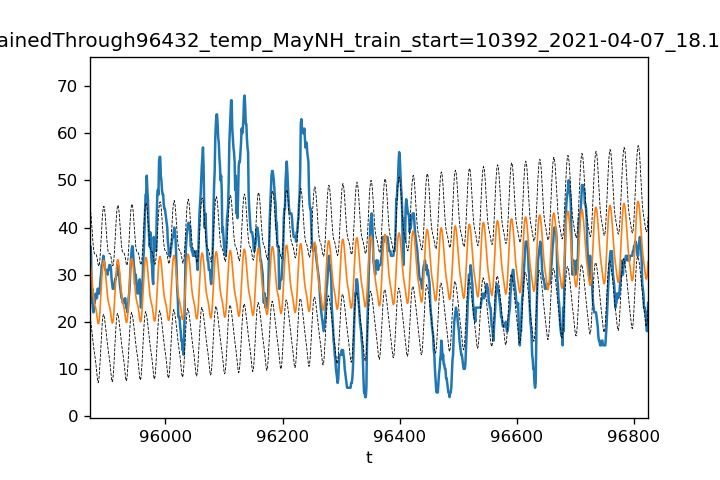

In [62]:
params = k_tmp.predict(predict_through)
mu_hat, sigma_hat, a_hat = params

# rescale
test_start = train_through + delay
sigh, ah = sigma_hat, a_hat
delta = ah / np.sqrt(1 + ah ** 2)
muh = mu_hat * rnge_tmp + (rnge_tmp - 1) * delta * sigh * np.sqrt(2 / np.pi)
muh = muh + mean_tmp - (rnge_tmp - 1) * delta * sigh * np.sqrt(2 / np.pi)
sigh = sigh * rnge_tmp

tmp_mean_hat = model_tmp.mean([muh, sigh, ah])
tmp_std_hat = model_tmp.std([muh, sigh, ah])

%matplotlib notebook
plt.figure(dpi=100)
plt.subplot(111)
dim=0
plt.plot(temps_original[train_start:][:predict_through])
plt.plot(tmp_mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(tmp_mean_hat[:, dim] + tmp_std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(tmp_mean_hat[:, dim] - tmp_std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
# plt.legend()
plt.show()

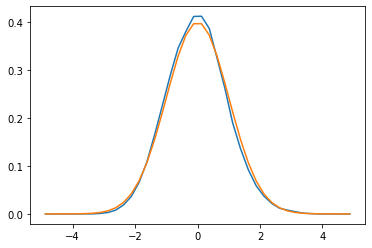

In [61]:
temp_zs = (np.expand_dims(temps_original[train_start:][:predict_through], -1) - tmp_mean_hat) / tmp_std_hat
z_hist, bin_edges = np.histogram(temp_zs, bins=40, range=(-5, 5), density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
%matplotlib inline
plt.plot(z_axis, z_hist)
plt.plot(z_axis, normal_pdf(0, 1, z_axis))

<IPython.core.display.Javascript object>


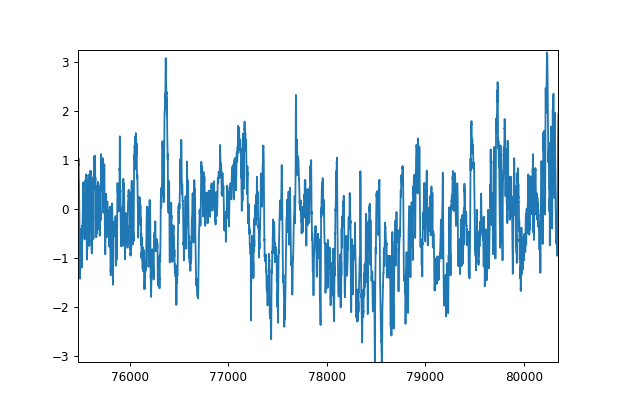

In [63]:
%matplotlib notebook
plt.plot(temp_zs)

# Subtract off temperature effects and trend line

<IPython.core.display.Javascript object>


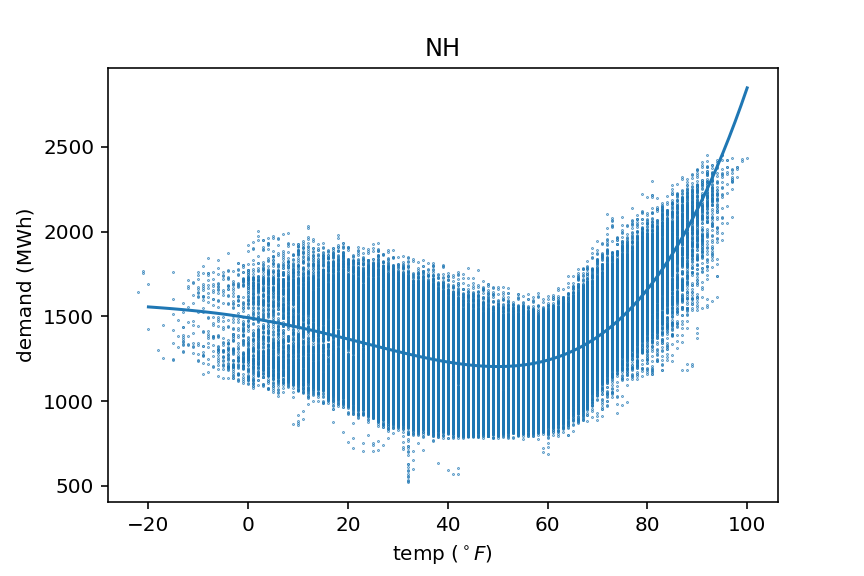

Text(0, 0.5, 'demand (MWh)')

In [30]:
reg_temp = linear_model.LinearRegression()
inputs = np.array([temps, temps**2, temps**4]).T
reg_temp.fit(inputs, demand)
lins = np.linspace(-20, 100, 100)
varis = np.array([lins, lins**2, lins**4]).T
fit = reg_temp.predict(varis)
plt.figure(dpi=120)
plt.scatter(temps, demand, s=0.1)
plt.plot(lins, fit)
plt.title(zone_name)
plt.xlabel("temp ($^\circ F$)")
plt.ylabel("demand (MWh)")

<IPython.core.display.Javascript object>


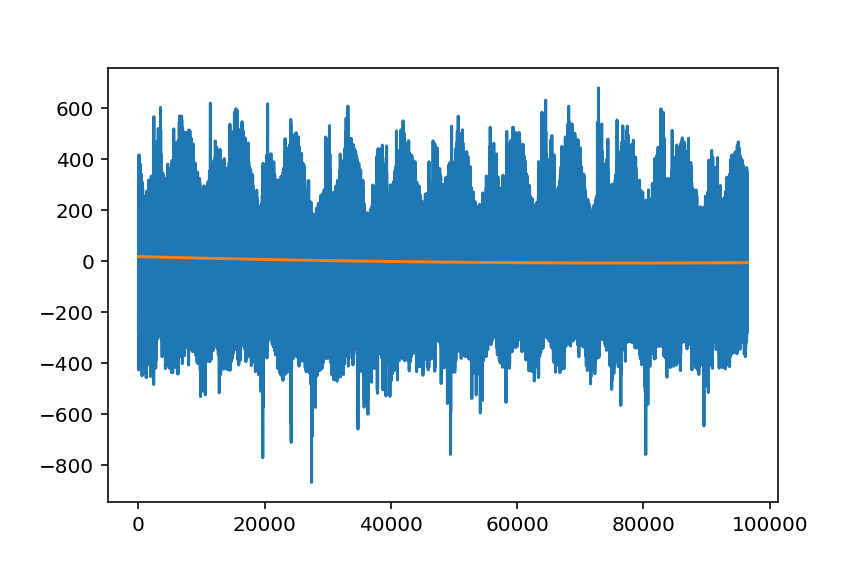

array([-6.47144065e-04,  4.15826510e-09])

In [31]:
temp_fit = reg_temp.predict(inputs)
demandmt = demand - temp_fit
annual_means = []
year_midpoints = []
for year in range(11):
    year_midpoints.append(8760 * (year + 0.5))
    annual_means.append(np.mean(demandmt[8760 * year:8760 * (year + 1)]))
reg2 = linear_model.LinearRegression()
t_vec = np.array(year_midpoints, dtype=np.float64)
t_vec = np.array([t_vec, t_vec**2]).T
reg2.fit(t_vec, annual_means)
t_vec = np.arange(len(demandmt), dtype=np.float64)
t_vec = np.array([t_vec, t_vec**2]).T
trend_curve = reg2.predict(t_vec)
plt.figure(dpi=120)
plt.plot(demandmt)
plt.plot(trend_curve)
reg2.coef_

In [15]:
xt = np.expand_dims(demandmt - trend_curve, -1)
mean = np.mean(xt, axis=0)
rnge = np.max(xt, axis=0) - np.min(xt, axis=0)
xt = (xt - np.matlib.repmat(mean, xt.shape[0], 1)) / np.matlib.repmat(rnge, xt.shape[0], 1)

In [16]:
mask = torch.ones(xt.shape, dtype=torch.uint8)
mask[:pre_length] = 0
num_freqs = [4, 4, 4]
num_fourier = 4
loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 11 * 2 * np.pi, xt.shape[0]) - 2 * np.pi * delay / 8760)
recency_weights = 1/(1 + torch.exp((3*xt.shape[0] / 4 - torch.arange(xt.shape[0])) / (xt.shape[0] / 10))) + 0.6
recency_weights[:pre_length] = 1
loss_weights *= recency_weights
print("xt", xt.shape)

now = ("_".join(str(datetime.now()).split())).replace(":", ".")

### TRAIN ###
model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32, loss_weights=loss_weights)

k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
data_name = "performance_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now

k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask)

fname = "experiments\\vanilla_comp\\temperature_model" + data_name + f"trained{train_start}-{train_through}_"
mu_file = fname + "mu.npy"
sigma_file = fname + "sigma.npy"
alpha_file = fname + "alpha.npy"

xt (96432, 1)
Loss at iteration 10: -1.6086491010691655
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cau

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

In [17]:
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params

# rescale
test_start = train_through + delay
sigh, ah = sigma_hat, a_hat
delta = ah / np.sqrt(1 + ah ** 2)
muh = mu_hat * rnge + (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
muh = muh + mean - (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
sigh = sigh * rnge

# add back other temp and trend fits
t_vec = np.arange(predict_through, dtype=np.float64)
t_vec = np.array([t_vec, t_vec**2]).T
trend_curve = np.expand_dims(reg2.predict(t_vec), -1)
muh += trend_curve
# TODO don't use future temperature data
temps = temps_original[train_start:][:predict_through]
inputs = np.array([temps, temps**2, temps**4]).T
temp_fit = np.expand_dims(reg_temp.predict(inputs), -1)
muh += temp_fit

mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

<IPython.core.display.Javascript object>


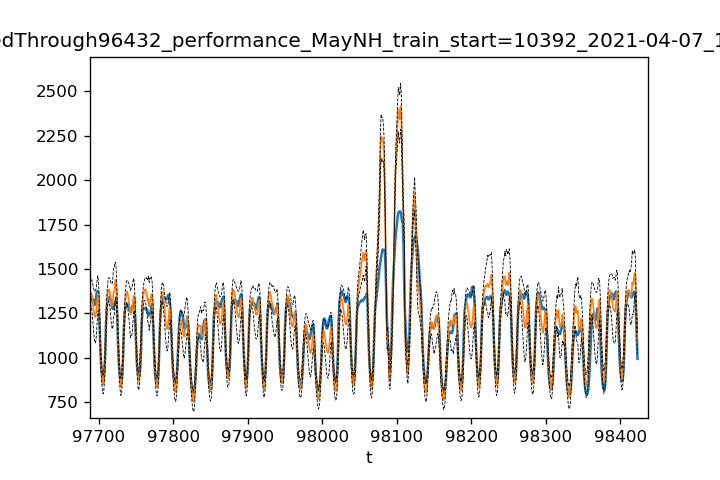

In [28]:
%matplotlib notebook
plt.figure(dpi=100)
plt.subplot(111)
dim=0
plt.plot(x_original[train_start:][:predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
# plt.legend()
plt.show()

In [26]:
print("actual overall mean:", np.mean(x_original[train_start:][:train_through]), " predicted mean:", np.mean(mean_hat[:train_through]))
# print("actual mu train mean:", np.mean(x_original[pre_length:]), " predicted mean:", np.mean(mean_hat[pre_length:train_through]))

z_scores.append((np.expand_dims(x_original[train_start:][:train_through], -1) - mean_hat[:train_through]) / std_hat[:train_through])
test_z_scores.append(
    (np.expand_dims(x_original[train_start:][train_through + delay:predict_through], -1) - mean_hat[train_through + delay:predict_through]) 
     / std_hat[train_through + delay:predict_through])
print("mean test z-score:", np.mean(test_z_scores[-1]))
print("std test z-score:", np.std(test_z_scores[-1]))

actual overall mean: 1325.089343568525  predicted mean: 1330.5526854807792
mean test z-score: -0.19232419970420275
std test z-score: 1.1154005354865704


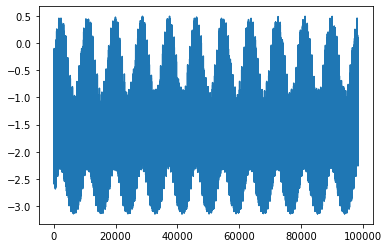

In [27]:
%matplotlib inline
plt.plot(ah)

# Test

In [22]:
%matplotlib inline
z_scores = []
test_z_scores = []
losses = []
relative_perfs = []

ZONE: ISONE CA
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.5272453418264993
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF A

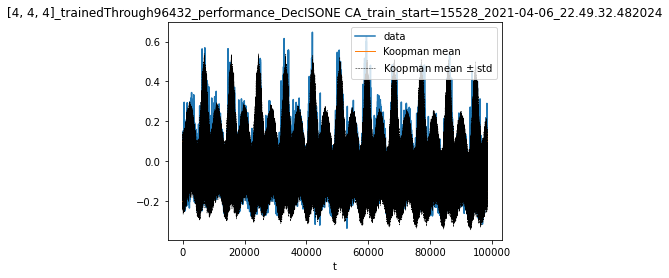

actual overall mean: 1.6210324567282856e-18  predicted mean: -0.0051977113
actual mu train mean: 0.002579210843133107  predicted mean: -0.01816992
mean test z-score: 0.49478691289068877
std test z-score: 1.1759059743011826


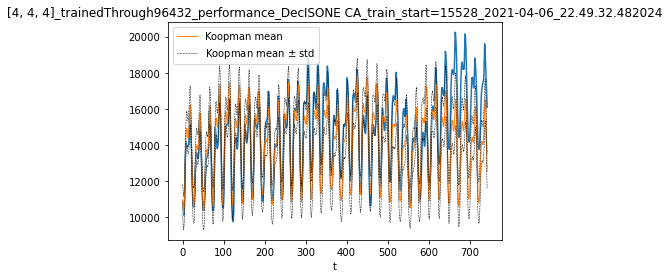

pinball_loss: 406.6686628541285
7.7467447625837345% performance relative to vanilla benchmark





ZONE: ME
data (113952, 1)
x (98424, 1)
xt (96432, 1)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise caus

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Loss at iteration 60: -1.7715998721567283
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical i

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

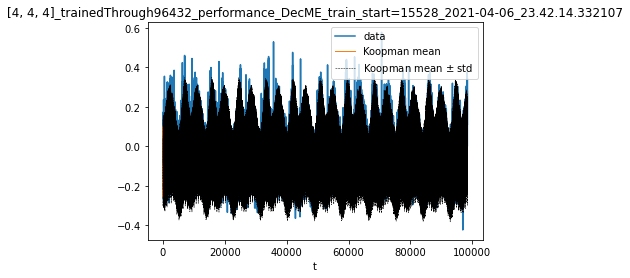

actual overall mean: -8.841995218517921e-19  predicted mean: -0.003945334
actual mu train mean: 0.004079333608991398  predicted mean: -0.0070978915
mean test z-score: 0.7094383094180657
std test z-score: 1.0443069474615958


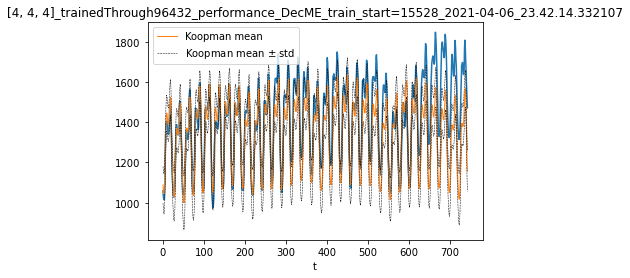

pinball_loss: 35.76497590029621
2.751280399789069% performance relative to vanilla benchmark





ZONE: RI
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.7270580310728945
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
Loss at iteration 60: -2.027398900455011
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical ins

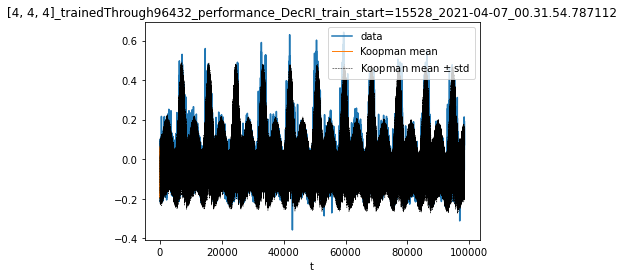

actual overall mean: 5.894663479011948e-19  predicted mean: -0.0033958734
actual mu train mean: 0.0018486149697497195  predicted mean: -0.007725046
mean test z-score: 0.32790200673054665
std test z-score: 1.050604856481117


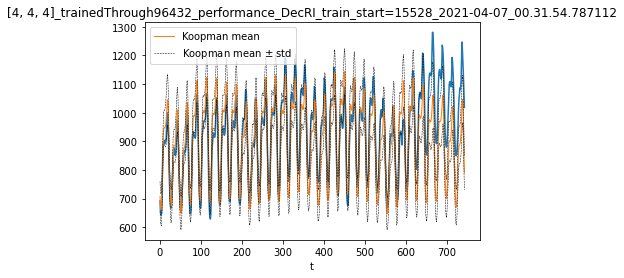

pinball_loss: 23.100710924843362
5.095160063289295% performance relative to vanilla benchmark





ZONE: VT
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.1618629646551684
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

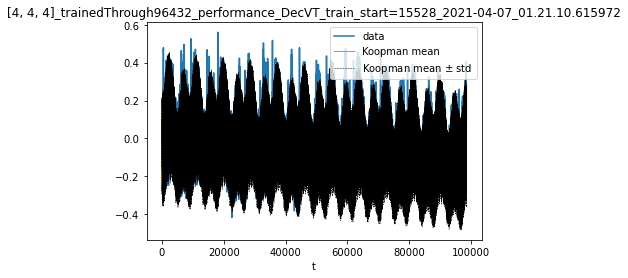

actual overall mean: -2.947331739505974e-18  predicted mean: -0.006856738
actual mu train mean: 0.0028340868795972037  predicted mean: -0.041571498
mean test z-score: 0.7196628020783118
std test z-score: 1.0272695181074303


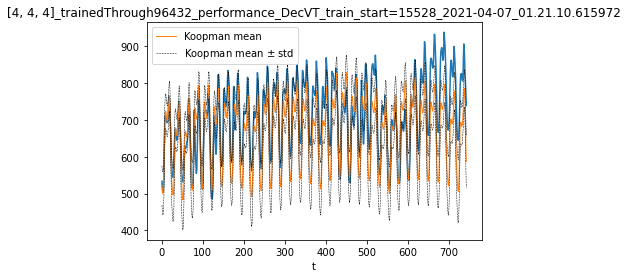

pinball_loss: 21.525103971701053
2.409106175597975% performance relative to vanilla benchmark





ZONE: CT
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.534962084023273
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROX

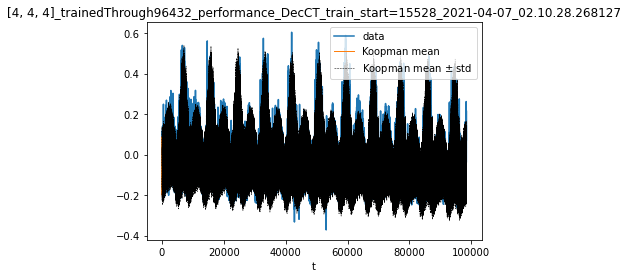

actual overall mean: -1.6210324567282856e-18  predicted mean: -0.007288596
actual mu train mean: 0.0025479597162096014  predicted mean: -0.022720924
mean test z-score: 0.6029558763987135
std test z-score: 1.1151608257505712


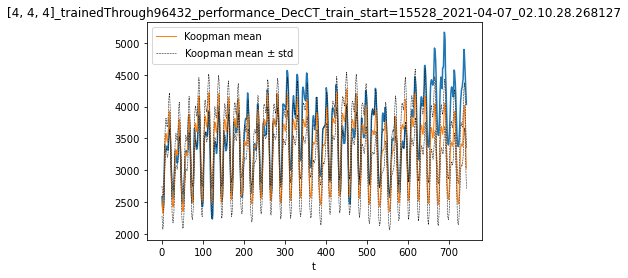

pinball_loss: 116.1788533217118
3.7611396972245026% performance relative to vanilla benchmark





ZONE: NH
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.6568875408349728
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

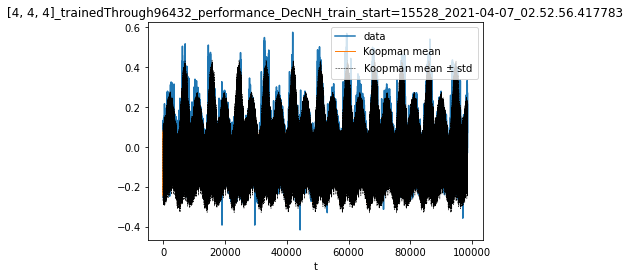

actual overall mean: 0.0  predicted mean: -0.0093921805
actual mu train mean: 0.0027970198951379147  predicted mean: -0.010306962
mean test z-score: 0.7472307383847758
std test z-score: 1.0313239868844577


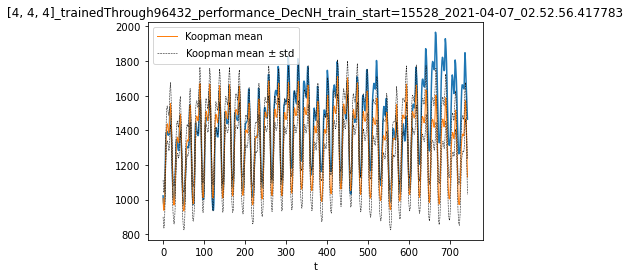

pinball_loss: 41.76353852370928
-4.532587382170172% performance relative to vanilla benchmark





ZONE: SEMASS
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.722325918440954
Loss at iteration 60: -1.9784352028156797
Loss at iteration 110: -1.992658206691441
Final loss: -1.9954987077273834


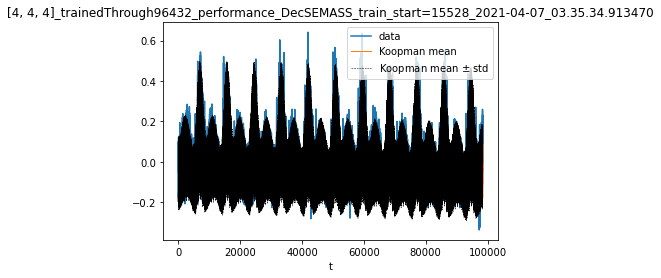

actual overall mean: -2.2104988046294803e-18  predicted mean: -0.0079819225
actual mu train mean: 0.0025914823732344347  predicted mean: -0.014931186
mean test z-score: 0.6372856607451562
std test z-score: 1.1616880116235888


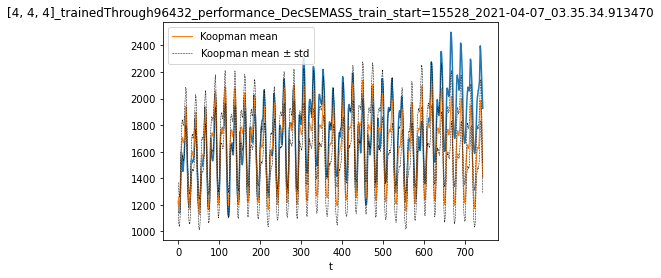

pinball_loss: 56.069957068343626
1.5356316103358525% performance relative to vanilla benchmark





ZONE: WCMASS
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.5552018809288177
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF 

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPROXIMATION (large z-score can otherwise cause numerical instability)
THIS BATCH USING LOG CDF APPRO

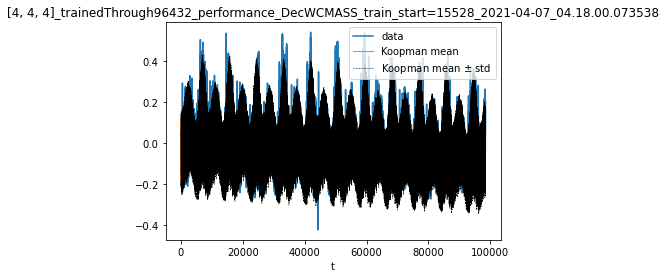

actual overall mean: 2.2104988046294803e-18  predicted mean: -0.0050389874
actual mu train mean: 0.0020084114305486374  predicted mean: -0.023528716
mean test z-score: 0.6221136286135418
std test z-score: 1.104851349564643


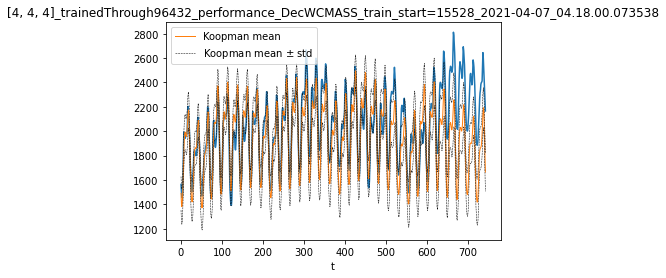

pinball_loss: 61.26079392441443
8.83709367136144% performance relative to vanilla benchmark





ZONE: NEMASSBOST
data (113952, 1)
x (98424, 1)
xt (96432, 1)
Loss at iteration 10: -1.4591081068578693
Loss at iteration 60: -1.8378093097734576
Loss at iteration 110: -1.8553120714020641
Final loss: -1.8571992775152766


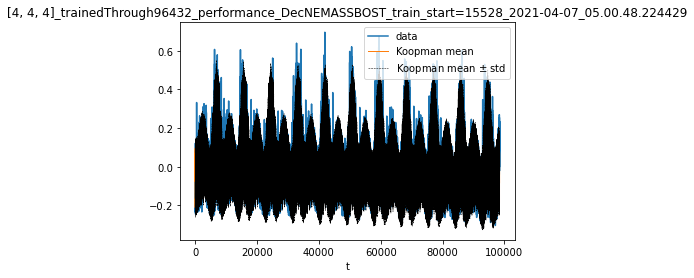

actual overall mean: -8.841995218517921e-19  predicted mean: 0.0027882599
actual mu train mean: 0.0015119151673338392  predicted mean: -0.008682798
mean test z-score: 0.21848156877924765
std test z-score: 1.185600398230464


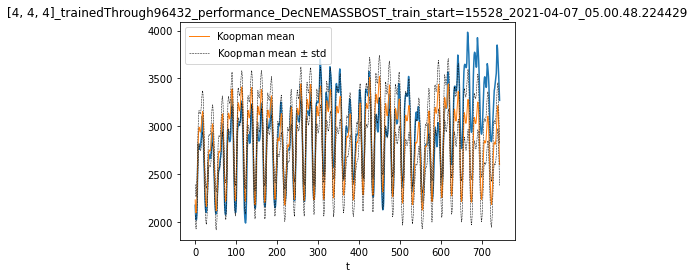

pinball_loss: 78.41109535174826
7.718775934482203% performance relative to vanilla benchmark







In [14]:
for zone_name in zones:
    print("ZONE:", zone_name)
    data = np.array([all_data[zone_name]["DEMAND"]], dtype=np.float64).T
    
    # rescale data
    x_original = data
    mean = np.mean(data, axis=0)
    rnge = np.max(data, axis=0) - np.min(data, axis=0)
    data = (data - np.matlib.repmat(mean, data.shape[0], 1)) / np.matlib.repmat(rnge, data.shape[0], 1)
    print("data", data.shape)

    predict_through = train_through + delay + test_length
    x = data[train_start:][:predict_through]
    xt_trendy = x[:train_through]
    reg = linear_model.LinearRegression()
    t_vec = np.arange(train_through).reshape(-1, 1)
    reg.fit(t_vec, xt_trendy)
    trend_line = reg.predict(t_vec)
    xt = xt_trendy - trend_line
    
    mask = torch.ones(xt.shape, dtype=torch.uint8)
    mask[:pre_length] = 0
    num_freqs = [4, 4, 4]
    num_fourier = 4
    loss_weights = 1 + 0.4 * torch.cos(torch.linspace(0, 11 * 2 * np.pi, xt.shape[0]) - 2 * np.pi * delay / 8760)
    recency_weights = 1/(1 + torch.exp((3*xt.shape[0] / 4 - torch.arange(xt.shape[0])) / (xt.shape[0] / 10))) + 0.6
    recency_weights[:pre_length] = 1
    loss_weights *= recency_weights
    print("x", x.shape)
    print("xt", xt.shape)

    now = ("_".join(str(datetime.now()).split())).replace(":", ".")

    ### TRAIN ###
    model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
    k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32, loss_weights=loss_weights)

    k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.24])
    data_name = "performance_" + months[month_idx] + zone_name + f"_train_start={train_start}_" + now

    k.fit(xt, iterations=120, verbose=False, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0, training_mask=mask);

    fname = "experiments\\vanilla_comp\\" + data_name + f"trained{train_start}-{train_through}_"
    mu_file = fname + "mu.npy"
    sigma_file = fname + "sigma.npy"
    alpha_file = fname + "alpha.npy"    

    ### FORECAST ###
    params = k.predict(predict_through)
    mu_hat, sigma_hat, a_hat = params

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    # ADD BACK THE TREND
    trend_line = reg.predict(np.arange(predict_through).reshape(-1, 1))
    mu_hat += trend_line
    
    np.save(mu_file, mu_hat)
    np.save(sigma_file, sigma_hat)
    np.save(alpha_file, a_hat)

    mean_hat = model.mean(params)
    std_hat = model.std(params)

    dim = 0
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    #plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    #plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    ### ANALYTICS ###
    print("actual overall mean:", np.mean(xt), " predicted mean:", np.mean(mean_hat[:train_through]))
    print("actual mu train mean:", np.mean(xt[pre_length:]), " predicted mean:", np.mean(mean_hat[pre_length:train_through]))

    z_scores.append((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
    test_z_scores.append(
        (x[train_through + delay:predict_through] - mean_hat[train_through + delay:predict_through]) 
         / std_hat[train_through + delay:predict_through])
    print("mean test z-score:", np.mean(test_z_scores[-1]))
    print("std test z-score:", np.std(test_z_scores[-1]))

    ### PERFORMANCE ###

    #Skew-Normal distribution Rescaling to de-normalize data because pinball loss is not scale-invariant
    test_start = train_through + delay
    sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
    delta = ah / np.sqrt(1 + ah ** 2)
    muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    muh = muh + mean - (rnge - 1) * delta * sigh * np.sqrt(2 / np.pi)
    sigh = sigh * rnge
    mean_hat = model.mean([muh, sigh, ah])
    std_hat = model.std([muh, sigh, ah])

    plt.figure()
    plt.plot(x_original[train_start:][test_start: predict_through])
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
    # plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
    # plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

    loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)[0]
    relative = (1 - loss/vanilla_losses[zone_name].iloc[month_idx]) * 100
    print("pinball_loss:", loss)
    print(f"{relative}% performance relative to vanilla benchmark" + "\n"*5)
    losses.append(loss)
    relative_perfs.append(relative)

# Figures

<IPython.core.display.Javascript object>


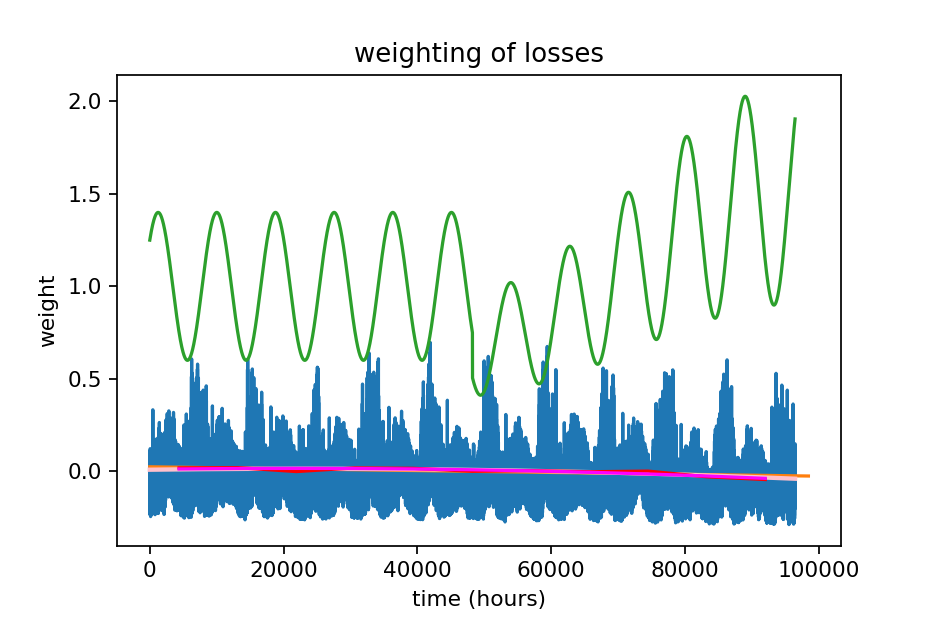

In [15]:
%matplotlib notebook
plt.figure(dpi=130)
annual_means = []
year_midpoints = []
for year in range(11):
    year_midpoints.append(8760 * (year + 0.5))
    annual_means.append(np.mean(xt_trendy[8760 * year:8760 * (year + 1)]))
reg2 = linear_model.LinearRegression()
t_vec = np.arange(train_through, dtype=np.float64)
t_vec = np.array([t_vec, t_vec**2]).T
reg2.fit(t_vec, xt_trendy)
trend_curve = reg2.predict(t_vec)
reg3 = linear_model.LinearRegression()
t_vec = np.array(year_midpoints)
t_vec = np.array([t_vec, t_vec**2]).T
reg3.fit(t_vec, annual_means)
trend_curve3 = reg3.predict(t_vec)
plt.plot(xt_trendy)
plt.plot(trend_line, linewidth=1.5)
plt.plot(trend_curve, color="pink", linewidth=2)
plt.plot(year_midpoints, annual_means, color="red")
plt.plot(year_midpoints, trend_curve3, color="magenta")

In [16]:
plt.plot(loss_weights)
plt.title("weighting of losses")
plt.ylabel("weight")
plt.xlabel("time (hours)")
plt.show()
print("Accounts for recency and how close to the testing time of year it is.\nThe recency effect is ignored for the portion of the training set that is not seen by mu.")

Accounts for recency and how close to the testing time of year it is.
The recency effect is ignored for the portion of the training set that is not seen by mu.


In [17]:
z_scores = np.array(z_scores)
test_z_scores = np.array(test_z_scores)
losses = np.array(losses)
relative = np.array(relative_perfs)

In [18]:
np.save("experiments\\vanilla_comp\\" + data_name + "z_scores.npy", z_scores)
np.save("experiments\\vanilla_comp\\" + data_name + "test_z_scores.npy", test_z_scores)
np.save("experiments\\vanilla_comp\\" + data_name + "relative_perfs.npy", relative_perfs)
np.save("experiments\\vanilla_comp\\" + data_name + "losses.npy", losses)

In [19]:
np.mean(losses), np.mean(relative_perfs)

(93.41596576009961, 3.924704992499322)

In [20]:
# for tables
for loss in losses[:9]:
    print(np.round(loss, 1), end="\t")
print("")
for rel in relative_perfs[:9]:
    print(np.round(rel, 1), end="%\t")

406.7	35.8	23.1	21.5	116.2	41.8	56.1	61.3	78.4	
7.7%	2.8%	5.1%	2.4%	3.8%	-4.5%	1.5%	8.8%	7.7%	

In [21]:
idx = 9
for z_score in z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
# for z_score in z_scores[:idx]:
#     print(np.round(skew(z_score)[0], 2), end="\t")
# print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.mean(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(np.std(z_score), 2), end="\t")
print()
for z_score in test_z_scores[:idx]:
    print(np.round(skew(z_score)[0], 2), end="\t")

0.01	0.01	0.03	-0.03	0.03	0.18	0.11	-0.02	-0.09	
0.99	0.95	0.97	0.93	0.96	0.99	0.94	0.97	0.99	
0.49	0.71	0.33	0.72	0.6	0.75	0.64	0.62	0.22	
1.18	1.04	1.05	1.03	1.12	1.03	1.16	1.1	1.19	
0.52	0.57	0.64	-0.52	0.3	0.29	0.39	0.49	0.56	

In [21]:
np.round(np.mean(np.std(test_z_scores, axis=1)), 2)

0.93

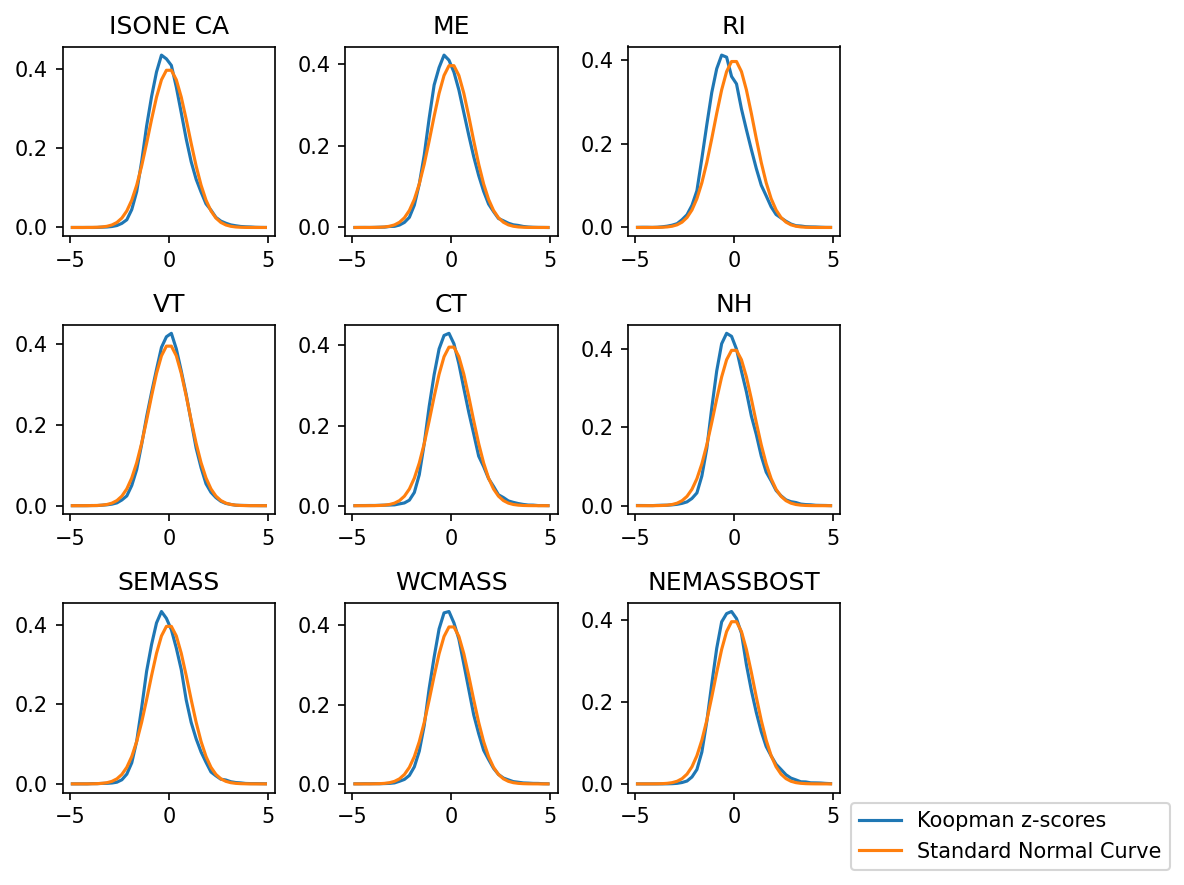

In [22]:
%matplotlib inline
z_hists = []
plt.subplots(dpi=150, figsize=(8, 6))
for i, z_score in enumerate(z_scores):
    month = 2*i
    z_hist, bin_edges = np.histogram(z_score, bins=40, range=(-5, 5), density=True)
    z_hists.append(z_hist)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
#     print(f"mean of z-scores in month {months[month]}:", np.mean(z_score), "std of z-scores:", np.std(z_score))
    
    plt.subplot(3, 3, i + 1)
    plt.plot(z_axis, z_hist, label="Koopman z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(zones[i])
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

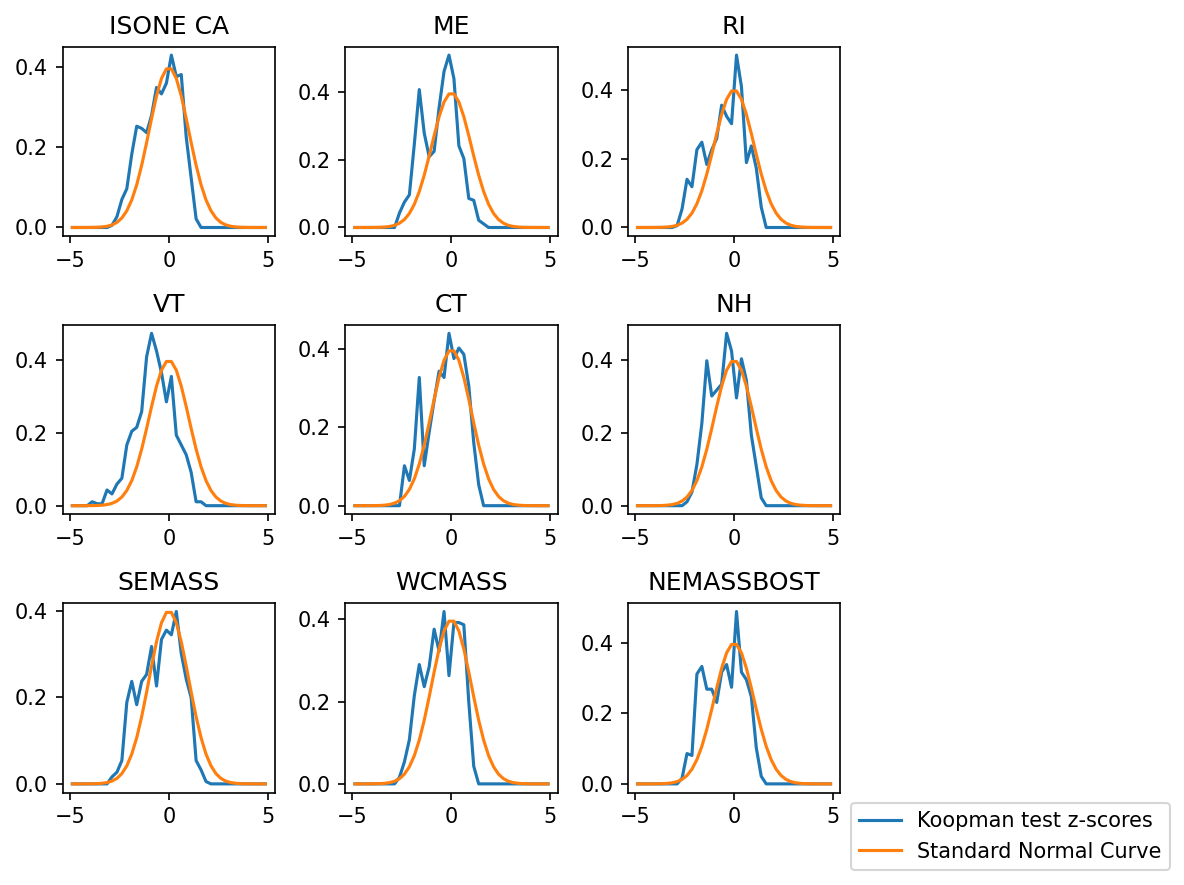

In [23]:
%matplotlib inline
test_z_hists = []
plt.subplots(dpi=150, figsize=(8, 6))
for i, z_score in enumerate(test_z_scores):
    month = 2 * i
    z_hist, bin_edges = np.histogram(z_score, bins=40, range=(-5, 5), density=True)
    test_z_hists.append(z_hist)
    z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
#     print(f"mean of z-scores in month {month}:", np.mean(z_score), "std of z-scores:", np.std(z_score))
    
    plt.subplot(3, 3, i + 1)
    plt.plot(z_axis, z_hist, label="Koopman test z-scores")
    plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
    plt.title(zones[i])
#     plt.xlabel("z")
plt.legend(loc="upper left", bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.show()

(-0.48067210306814695, 0.9287151438805792)

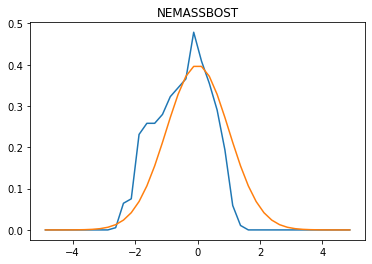

In [24]:
z_score = test_z_scores.mean(axis=0)
z_hist, bin_edges = np.histogram(z_score, bins=40, range=(-5, 5), density=True)
test_z_hists.append(z_hist)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.plot(z_axis, z_hist, label="Koopman test z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title("average over " + month_name)
np.mean(test_z_scores), np.mean(np.std(test_z_scores, axis=1))